In [1]:
import os
os.chdir('../')

In [2]:
device = 'cpu'

In [3]:
import numpy as np
import argparse
import time
from itertools import chain
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from datasets import inputs
from sr_model.models.models import AnalyticSR, STDP_SR
from sr_model.utils import get_sr, debug_plot

## Set RBYCacheWalk dataset parameters

In [4]:
# Dataset Configs
num_spatial_states = 10**2
dataset = inputs.RBYCacheWalk(
    num_spatial_states=num_spatial_states, downsample_factor=None, skip_frame=None,
    vel_thresh=4, event_window=5
    )

In [5]:
wedge_states, cache_interactions = dataset.get_rel_vars()

## Initialize Network

In [6]:
# Init net
net = AnalyticSR(num_states=dataset.num_states, gamma=0.7)

## Run network and get learned M

In [7]:
# Make input
dg_inputs = torch.from_numpy(dataset.dg_inputs.T).float().to(device).unsqueeze(1)
dg_modes = torch.from_numpy(dataset.dg_modes.T).float().to(device).unsqueeze(1)

with torch.no_grad():
    _, outputs = net(dg_inputs, dg_modes)

In [8]:
M = get_sr(net.ca3.get_T(), 0.99)

## Plot function

In [9]:
def debug_plot(state_vector, input, title, save_title=None):
    spatial_mat, context_vec = input.unravel_state_vector(state_vector)
    context_vec = context_vec.squeeze()
    vmax = np.max([spatial_mat.max(), context_vec.max()])
    if vmax == 0:
        vmax = 1
    context_mat = np.zeros(input.num_spatial_states)
    wedge_states, cache_interactions = input.get_rel_vars()
    context_mat[wedge_states] = context_vec
    context_mat = context_mat.reshape(spatial_mat.shape)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    plt.suptitle(title)

    ax.imshow(spatial_mat+context_mat, vmin=0, vmax=vmax)
    ax.set_xticks([]); ax.set_yticks([]);

    for cache, interaction_amt in enumerate(cache_interactions):
        if interaction_amt == 0: continue
        anchor_point = np.unravel_index([wedge_states[cache]], context_mat.shape)
        anchor_point = [anchor_point[1] - 0.5, anchor_point[0] - 0.5]
        rect1 = patches.Rectangle(
            anchor_point, 1, 1, linewidth=1.5, edgecolor='red', facecolor='none'
            )
        ax.add_patch(rect1)
        
    if save_title is not None:
        plt.savefig(f'{save_title}.png', dpi=500)
        plt.savefig(f'{save_title}.pdf', dpi=500)
    plt.show()

## Plot Query

In [10]:
import matplotlib.patches as patches

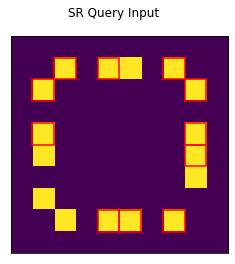

In [12]:
query = np.zeros(dataset.num_states)
query[-16:] = 1
save_title = f'episode_query'
debug_plot(
    query, dataset, "SR Query Input",
    save_title=save_title
    )

## Plot Most Interacted-With Sites

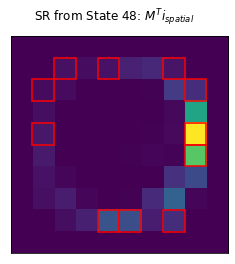

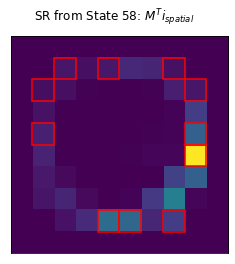

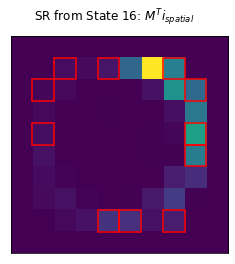

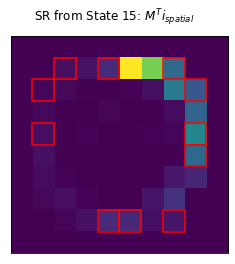

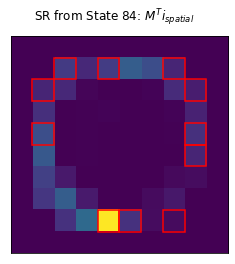

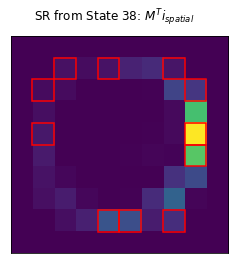

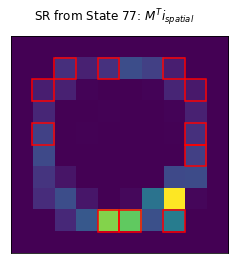

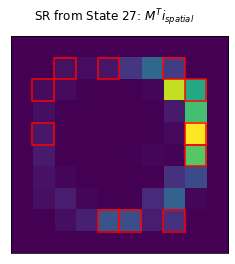

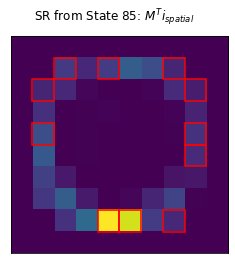

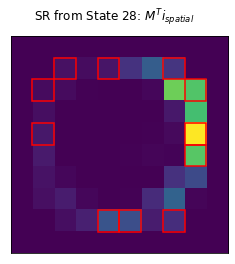

In [35]:
for state in dataset.sorted_states[:10]:
    query = np.zeros(dataset.num_states)
    query[state] = 1
    sr_output = M.T @ query
    debug_plot(sr_output, dataset, "SR from State %s: $M^Ti_{spatial}$"%state)

## Plot Place Cells

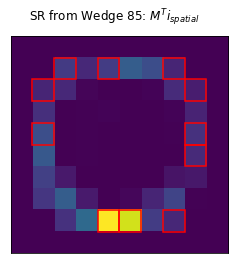

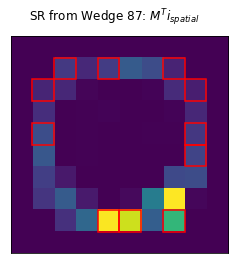

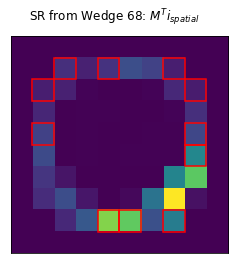

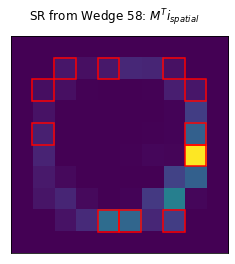

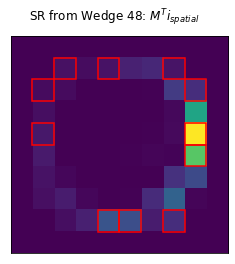

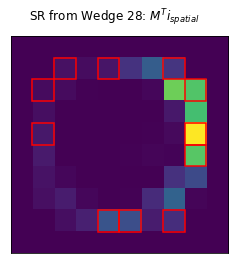

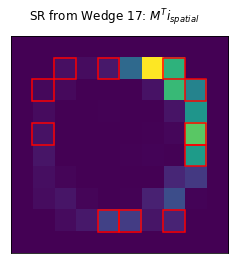

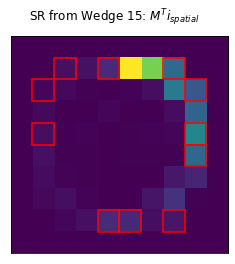

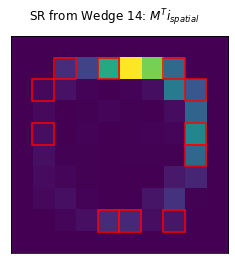

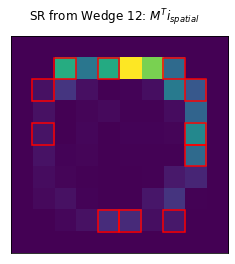

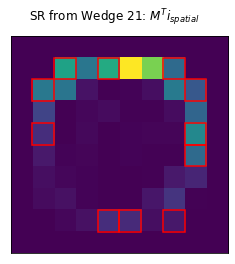

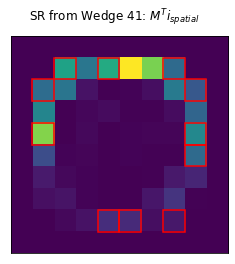

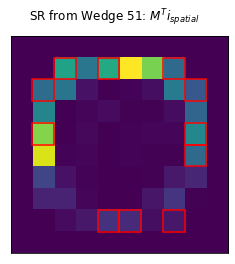

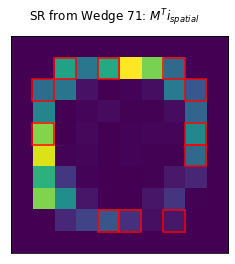

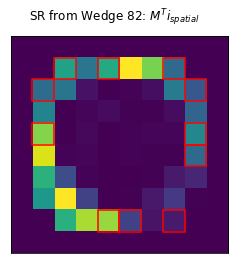

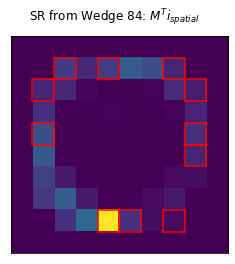

In [39]:
wedge_states, cache_interactions = dataset.get_rel_vars()
for idx, wedge in enumerate(wedge_states):
    query = np.zeros(dataset.num_states)
    query[wedge] = 1
    sr_output = M.T @ query
    if idx in [5, 9]:
        save_title = f'episode_sim_p{idx}'
    else:
        save_title = None
    debug_plot(
        sr_output, dataset, "SR from Wedge %s: $M^Ti_{spatial}$"%wedge,
        save_title=save_title
        )

## Plot Episode Cells

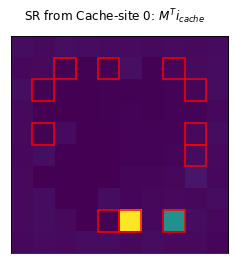

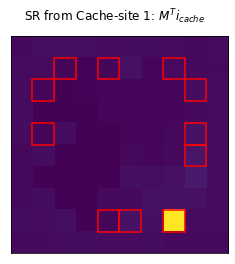

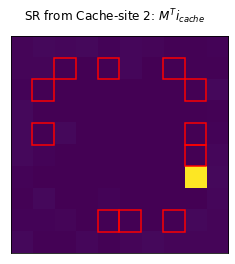

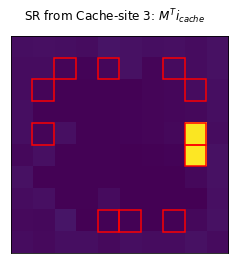

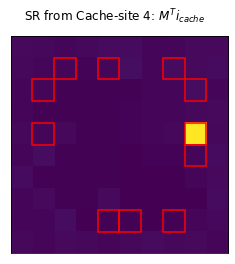

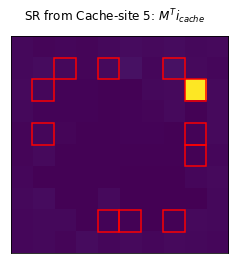

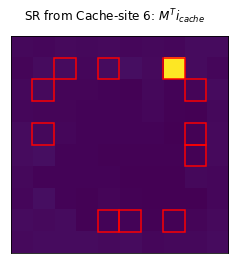

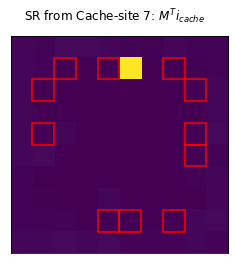

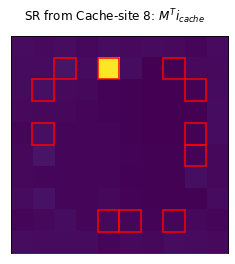

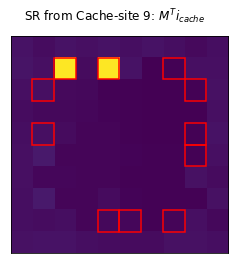

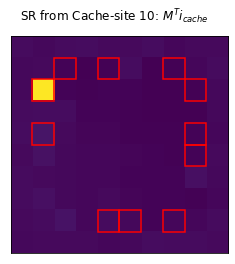

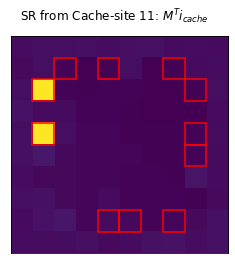

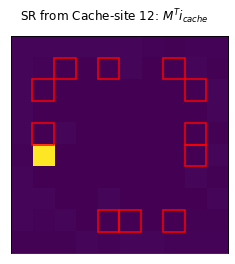

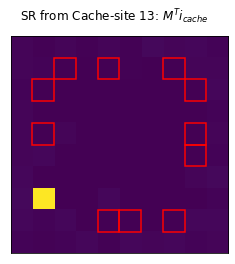

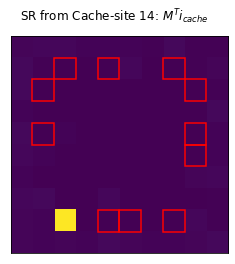

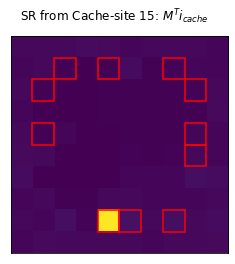

In [14]:
for cache in np.arange(16):
    query = np.zeros(dataset.num_states)
    query[-(16-cache)] = 1
    sr_output = M @ query
    if cache in [5]:
        save_title = f'episode_sim_c{cache}'
    else:
        save_title = None
    debug_plot(
        sr_output, dataset, "SR from Cache-site %s: $M^Ti_{cache}$"%cache,
        save_title=save_title
        )